In [75]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"parkjeongyeol","key":"2829620be97f119eda3004d8b67e9f7c"}'}

In [76]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json
# 내가 참가한 대회 리스트 확인
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         78           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes         79           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        598           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        134           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1485           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      14672            True  
house-pr

In [77]:
!kaggle datasets download -d kneroma/tacotrashdataset

100% 2.77G/2.79G [00:49<00:00, 53.1MB/s]
100% 2.79G/2.79G [00:49<00:00, 60.5MB/s]


In [78]:
!unzip /content/tacotrashdataset.zip

Archive:  /content/tacotrashdataset.zip
  inflating: best-checkpoint-003epoch.bin  
  inflating: data/annotations.json   
  inflating: data/batch_1/000000.jpg  
  inflating: data/batch_1/000001.jpg  
  inflating: data/batch_1/000003.jpg  
  inflating: data/batch_1/000004.jpg  
  inflating: data/batch_1/000005.jpg  
  inflating: data/batch_1/000006.jpg  
  inflating: data/batch_1/000007.jpg  
  inflating: data/batch_1/000008.jpg  
  inflating: data/batch_1/000010.jpg  
  inflating: data/batch_1/000011.jpg  
  inflating: data/batch_1/000012.jpg  
  inflating: data/batch_1/000013.jpg  
  inflating: data/batch_1/000014.jpg  
  inflating: data/batch_1/000015.jpg  
  inflating: data/batch_1/000016.jpg  
  inflating: data/batch_1/000017.jpg  
  inflating: data/batch_1/000019.jpg  
  inflating: data/batch_1/000021.jpg  
  inflating: data/batch_1/000022.jpg  
  inflating: data/batch_1/000023.jpg  
  inflating: data/batch_1/000024.jpg  
  inflating: data/batch_1/000025.jpg  
  inflating: data/ba

In [79]:
!pip install pycocotools

## Faster RCNN

In [80]:
!git clone https://github.com/wimlds-trojmiasto/detect-waste.git

Cloning into 'detect-waste'...
remote: Enumerating objects: 928, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 928 (delta 71), reused 80 (delta 36), pack-reused 766
Receiving objects: 100% (928/928), 85.18 MiB | 13.49 MiB/s, done.
Resolving deltas: 100% (437/437), done.


In [81]:
import numpy as np
import os
os.chdir('/content/detect-waste/FastRCNN')
import torch
import pycocotools
import torch.utils.data
from PIL import Image
import pandas as pd
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T
from PIL import ImageDraw
import os.path as path
import re
import json

In [82]:
def parse_one_annot(path_to_data_file, filename):
    data = pd.read_csv(path_to_data_file)
    print(filename)
    boxes_array = data[data["filename"] == filename][["xmin", "ymin",        
    "xmax", "ymax"]].values
    print(boxes_array)
    return boxes_array

In [83]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
                fullPath = fullPath.replace(data_folder, '')
                allFiles.append(fullPath)  
    return allFiles

In [84]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):
        self.root = root
        self.transforms = transforms
        files = getListOfFiles(os.path.join(root))
        p = re.compile('batch')
        l2 = [ s for s in files if p.match(s) ]
        self.imgs = sorted(l2)
        self.path_to_data_file = data_file
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.imgs[idx])
        self.imgs[idx] = self.imgs[idx]
        img = Image.open(img_path).convert("RGB")
        box_list = parse_one_annot(self.path_to_data_file, self.imgs[idx])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
                 img, target = self.transforms(img, target)
        return img, target
    
    def __len__(self):
        return len(self.imgs)

In [85]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
    return model

In [86]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

## CSV 파일 만들기

In [87]:
data_file = '/content/data/annot.csv'
json_path = '/content/data/annotations.json'
annot_folder = '/content/data'
with open(json_path) as json_file: 
    data = json.load(json_file)

In [88]:
def export_data(data, dtype, file):
    img = data[dtype] 
    data_file = open(file, 'w') 
    csv_writer = csv.writer(data_file) 
    count = 0
    for i in img: 
        if count == 0: 
            header = i.keys() 
            csv_writer.writerow(header) 
            count += 1
        csv_writer.writerow(i.values()) 
    data_file.close()

In [89]:
import csv
export_data(data, 'images', os.path.join(annot_folder,'data_file.csv'))
export_data(data, 'annotations', os.path.join(annot_folder,'data_file2.csv'))
export_data(data, 'categories', os.path.join(annot_folder,'data_file3.csv'))

In [90]:
data3 = pd.read_csv(os.path.join(annot_folder,'data_file3.csv'))
data2 = pd.read_csv(os.path.join(annot_folder,'data_file2.csv'))
data = pd.read_csv(os.path.join(annot_folder,'data_file.csv'))

In [91]:
data = data.rename(columns={"id": "image_id"})
data3 = data3.rename(columns={"id": "category_id"})
data2 = data2.merge(data, on='image_id', how='left')
data2 = data2.merge(data3, on='category_id', how='left')
data2 = data2.rename(columns={"supercategory": "class"})
data2 = data2.rename(columns={"file_name": "filename"})
data2['bbox'] = data2['bbox'].map(lambda x: x.lstrip('[').rstrip(']'))
data2[['xmin','ymin','xmax','ymax']] = data2.bbox.str.split(",",expand=True,)

In [92]:
data2['xmax'] = data2['xmax'].astype(float) + data2['width'].astype(float)
data2['ymax'] = data2['ymax'].astype(float) + data2['height'].astype(float)

In [93]:
data2 = data2[['filename','width','height','class','xmin','ymin','xmax','ymax']]
data2.to_csv(data_file,index=False)

In [94]:
data2['class'].unique()

array(['Bottle', 'Carton', 'Bottle cap', 'Can', 'Pop tab', 'Cup',
       'Plastic bag & wrapper', 'Styrofoam piece', 'Other plastic',
       'Plastic container', 'Paper', 'Lid', 'Straw', 'Paper bag',
       'Broken glass', 'Plastic utensils', 'Glass jar', 'Food waste',
       'Squeezable tube', 'Shoe', 'Aluminium foil', 'Unlabeled litter',
       'Blister pack', 'Battery', 'Rope & strings', 'Cigarette',
       'Scrap metal', 'Plastic glooves'], dtype=object)

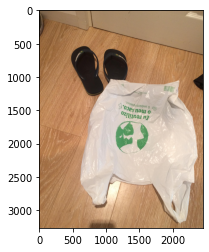

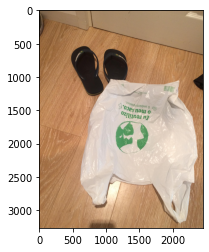

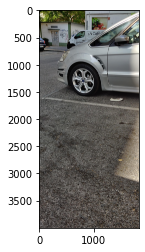

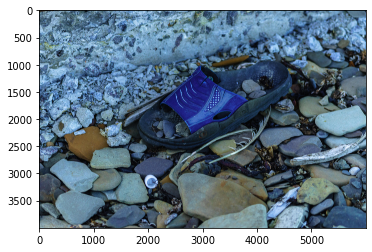

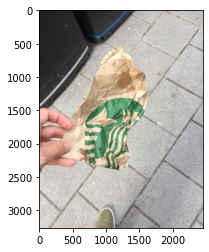

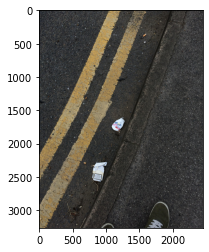

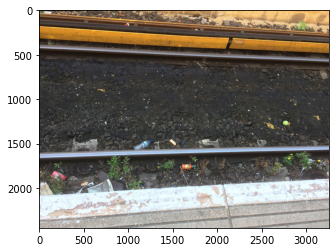

In [95]:
PATH = '/content/data/'
import matplotlib.pyplot as plt
for i in data2[data2['class'] == 'Shoe']['filename']:
  plt.imshow(Image.open(PATH  + i))
  plt.show()

In [96]:
data2['class'].unique()

array(['Bottle', 'Carton', 'Bottle cap', 'Can', 'Pop tab', 'Cup',
       'Plastic bag & wrapper', 'Styrofoam piece', 'Other plastic',
       'Plastic container', 'Paper', 'Lid', 'Straw', 'Paper bag',
       'Broken glass', 'Plastic utensils', 'Glass jar', 'Food waste',
       'Squeezable tube', 'Shoe', 'Aluminium foil', 'Unlabeled litter',
       'Blister pack', 'Battery', 'Rope & strings', 'Cigarette',
       'Scrap metal', 'Plastic glooves'], dtype=object)

In [97]:
import pandas as pd
def asd(x):
  if x in ['Plastic container','Straw','Other plastic','Plastic utensils','Squeezable tube']:
    x = 'Plastic'
  elif x in ['Glass jar','Broken glass']:
    x = 'Glass'
  elif x in 'Plastic bag & wrapper':
    x = 'Plastic bag'
  elif x in 'Pop tab':
    x = 'Can'
  else:
    pass

  return x

def dsa(x):
  if x in ['Paper','Carton','Can','Glass','Plastic','Plastic bag']:

    return x
  else:
    return np.NaN

data2['class'] = data2['class'].apply(lambda x:asd(x))

data2['class'] = data2['class'].apply(lambda x:dsa(x))

data2.dropna(inplace = True)

len(data2['class'].unique())

6

In [112]:
data_folder = '/content/data/'
data_file = '/content/data/annot.csv'
working_dir = '/content/detect-waste/FastRCNN'
num_classes = 6

dataset = Dataset(root= data_folder, data_file= data_file , transforms = get_transform(train=True))
dataset_test = Dataset(root= data_folder, data_file= data_file , transforms = get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
testing_num = int(len(dataset)*0.2)
dataset = torch.utils.data.Subset(dataset, indices[:-testing_num])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-testing_num:])
data_loader = torch.utils.data.DataLoader(
              dataset, batch_size=2, shuffle=True, num_workers=4,
              collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
         dataset_test, batch_size=1, shuffle=False, num_workers=4,
         collate_fn=utils.collate_fn)
print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

We have: 1500 examples, 1200 are training and 300 testing


In [113]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model(num_classes)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                       step_size=3,gamma=0.1)

In [114]:
num_epochs = 100
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 [2385. 1985. 3075. 4133.]
 [ 342. 1948. 3071. 4068.]
 [1798. 2113. 3112. 4116.]
 [1463. 1882. 3044. 4082.]
 [1765. 2067. 3058. 4093.]]
batch_15/000010.jpg
[[2781. 2216. 3101. 4112.]
 [2720. 2220. 3087. 4100.]
 [ 891. 2433. 3125. 4132.]
 [ 679. 2591. 3126. 4136.]
 [ 738. 2684. 3133. 4141.]
 [ 598. 1024. 3880. 4816.]
 [2525. 3113. 3065. 4080.]
 [ 333. 1448. 3171. 4106.]]
batch_15/000011.jpg
[[1445. 2076. 3278. 4546.]
 [2654.  697. 3108. 4066.]]
batch_15/000012.jpg
[[1304. 2103. 3271. 4254.]
 [ 943. 1855. 3171. 4210.]]
batch_15/000013.jpg
[[ 790. 2243. 3541. 4573.]
 [ 868. 2309. 3104. 4090.]
 [1529. 3422. 3143. 4159.]
 [1550. 3218. 3465. 4528.]
 [1565. 3652. 3230. 4199.]
 [ 714.  865. 3201. 4162.]
 [ 512.  789. 3181. 4107.]]
batch_15/000014.jpg
[[1338. 1411. 2532. 3736.]]
batch_15/000015.jpg
[[ 703. 1417. 3384. 2595.]
 [ 715.  860. 3319. 2474.]
 [1304.  879. 3371. 2484.]
 [1210. 1013. 3369. 2510.]
 [2920. 1124. 3338. 2507.]
 [2924. 1166. 3282. 2466.]
 

In [115]:
model_path = '/content/drive/MyDrive/인공지능 그랜드 챌린지/model.h5'
torch.save(model.state_dict(), model_path)

model_path = '/content/drive/MyDrive/인공지능 그랜드 챌린지/model.pth'
torch.save(model.state_dict(), model_path)

model_path = '/content/drive/MyDrive/인공지능 그랜드 챌린지/model.pt'
torch.save(model.state_dict(), model_path)

In [116]:
loaded_model = get_model(num_classes = num_classes)
loaded_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [142]:
prediction

[{'boxes': tensor([[1.7917e+02, 1.5226e+03, 2.6704e+02, 1.6664e+03],
          [9.6892e+02, 1.7679e+03, 1.4245e+03, 1.8921e+03],
          [9.4631e+02, 3.1002e+03, 1.2428e+03, 3.2640e+03],
          [7.6175e+02, 3.0185e+03, 1.2901e+03, 3.2399e+03],
          [5.5130e+02, 2.6238e+03, 6.6978e+02, 2.6783e+03],
          [9.5087e+02, 3.0578e+03, 1.2707e+03, 3.2096e+03],
          [1.4402e+03, 1.9235e+03, 1.6829e+03, 1.9791e+03],
          [1.1092e+02, 2.6639e+03, 2.4480e+03, 3.2640e+03],
          [5.4443e+02, 2.6667e+03, 6.2295e+02, 2.7255e+03],
          [9.6346e+02, 1.6575e+03, 1.7791e+03, 1.9425e+03],
          [9.0645e+02, 1.6523e+03, 9.4696e+02, 1.6775e+03],
          [1.6203e+03, 1.3685e+03, 1.6493e+03, 1.3978e+03],
          [2.0683e+03, 2.8499e+03, 2.4414e+03, 3.2160e+03],
          [2.6296e+02, 1.8983e+03, 2.9989e+02, 1.9271e+03],
          [8.9672e+02, 1.6364e+03, 9.4457e+02, 1.6822e+03],
          [5.9675e+02, 2.6591e+03, 6.9928e+02, 2.7564e+03],
          [5.1728e+02, 2.6276e+

In [141]:
idx = 14
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])
loaded_model.eval()
with torch.no_grad():
    prediction = loaded_model([img])
image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)
for elem in range(len(label_boxes)):
    draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
    (label_boxes[elem][2], label_boxes[elem][3])], 
    outline ="green", width =3)
for element in range(len(prediction[0]["boxes"])):
    boxes = prediction[0]["boxes"][element].cpu().numpy()
    score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
    if score > 0.8:
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
        outline ="red", width =3)
        draw.text((boxes[0], boxes[1]), text = str(score))
image

Output hidden; open in https://colab.research.google.com to view.

In [132]:
from glob import glob
test_path = '/content/drive/MyDrive/인공지능 그랜드 챌린지/dataset_4차_트랙3_sample/'

test = glob(test_path + '*.JPG')

test = sorted(test)

In [133]:
image = []
for i in test:

  img = Image.open(i)
  img = np.array(img)
  image.append(img)

In [134]:
for i in image:
  plt.imshow(i)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [136]:
with open('/content/drive/MyDrive/인공지능 그랜드 챌린지/dataset_4차_트랙3_sample/metadata.json', 'r') as f:
  anno = json.loads(f.read())

In [137]:
anno

{'backgroud': ['wood',
  ['wood', 'cement'],
  'cement',
  'cement',
  ['cement', 'waterspout'],
  'cement',
  'cement',
  'tile',
  'grass',
  'grass',
  ['cement', 'grass'],
  ['cement', 'waterspout'],
  ['wood', 'cement'],
  ['tree', 'cement'],
  'grass',
  'wood',
  'wood',
  ['cement', 'grass'],
  'grass',
  ['cement', 'waterspout'],
  'cement',
  'wood',
  'cement',
  'cement',
  ['stone', 'grass'],
  ['stone', 'grass'],
  ['wood', 'cement'],
  ['cement', 'waterspout'],
  'cement',
  ['grass', 'cement', 'waterspout']],
 'bbox_x1': [[260, 790, 1080, 1090],
  [610, 980, 670, 925],
  [550, 700, 870, 1010],
  [670, 780, 860, 885, 1080],
  [800, 850, 940, 1100],
  [685, 750, 830, 990, 1140],
  [800, 965, 975, 1100],
  [565, 855, 1050, 1155],
  [660, 825, 805, 825],
  [445, 600, 920, 670],
  [500, 590, 1000, 930],
  [440, 1000, 1065, 1130],
  [800, 850, 910, 1050],
  [730, 820, 915, 1050],
  [790, 790, 930, 970],
  [710, 970, 1100],
  [830, 825, 950, 1030, 1090],
  [830, 910, 1060],
  

In [138]:
loaded_model = get_model(num_classes = num_classes)

In [144]:
url = '/content/drive/MyDrive/인공지능 그랜드 챌린지/dataset_4차_트랙3_sample/metadata.json'
with open(url, 'r') as f:
  anno = json.loads(f.read())

In [147]:
anno.keys()

dict_keys(['fname', 'backgroud', 'label', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2'])

In [155]:
anno['bbox_x1']

[[260, 790, 1080, 1090],
 [610, 980, 670, 925],
 [550, 700, 870, 1010],
 [670, 780, 860, 885, 1080],
 [800, 850, 940, 1100],
 [685, 750, 830, 990, 1140],
 [800, 965, 975, 1100],
 [565, 855, 1050, 1155],
 [660, 825, 805, 825],
 [445, 600, 920, 670],
 [500, 590, 1000, 930],
 [440, 1000, 1065, 1130],
 [800, 850, 910, 1050],
 [730, 820, 915, 1050],
 [790, 790, 930, 970],
 [710, 970, 1100],
 [830, 825, 950, 1030, 1090],
 [830, 910, 1060],
 [755, 920, 1015],
 [630, 800, 1060, 1110, 1295],
 [750, 840, 860, 860, 970],
 [760, 890, 910, 950, 1080, 1070],
 [610, 640, 745, 940, 1215],
 [660, 745, 980, 995, 1120, 1240],
 [820, 880, 1010, 1020],
 [720, 930, 1020, 1090],
 [520, 780, 920, 1020, 1090],
 [620, 700, 800, 970, 1030],
 [450, 590, 720, 830, 1000, 1090],
 [705, 850]]

In [156]:
anno.keys()

dict_keys(['fname', 'backgroud', 'label', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2'])

In [162]:
final_bbox[0]

[[260, 340, 850, 1040],
 [790, 130, 1140, 680],
 [1080, 370, 1310, 670],
 [1090, 400, 1570, 570]]

In [163]:
# final_box에 이미지 index별로 x1, y1, x2, y2 순으로 데이터를 넣었다.
# 예를 들어서 final_bbox[0] 0번째 사진의 bbox가 전부 나오게 되는데
# [[260, 340, 850, 1040], 1번째 bbox 
#  [790, 130, 1140, 680], 2번째 bbox
#  [1080, 370, 1310, 670], 3번째 bbox
#  [1090, 400, 1570, 570]] 4번째 bbox 이런 식으로 구성되게 된다.
final_bbox = []

for i in range(len(anno['fname'])):

  bbox = []



  nr_img_label = len(anno['bbox_x1'][i])

  for j in range(nr_img_label):

    bbox_i = []
    
    bbox_i.append(anno['bbox_x1'][i][j])
    bbox_i.append(anno['bbox_y1'][i][j])
    bbox_i.append(anno['bbox_x2'][i][j])
    bbox_i.append(anno['bbox_y2'][i][j])

    bbox.append(bbox_i)

  final_bbox.append(bbox)

anno['bbox'] = final_bbox

In [165]:
with open('/content/drive/MyDrive/인공지능 그랜드 챌린지/dataset_4차_트랙3_sample/meta_data.json','w') as f:
  json.dump(anno, f)

In [171]:
class Test_dataLoader(torch.utils.data.Dataset):
  def __init__(self, root, data_file, transforms = None):
    self.root = root
    self.transforms = transforms

    files = glob(root + '/' + '*.JPG')

    self.imgs = sorted(files)

    self.data_file = data_file

    with open(self.data_file, 'r') as f:
      anno = json.loads(f.read())

    self.anno = anno
  def __getitem__(self, idx):
    img_path = self.imgs[idx]
    self.imgs[idx] = self.imgs[idx]

    img = Image.open(img_path).convert('RGB')

    box_list = anno['bbox'][idx]
    boxes = torch.as_tensor(box_list, dtype = torch.float32)
    num_objs = len(box_list)
    labels = torch.ones((num_objs,), dtype = torch.int64)

    image_id = torch.tensor([idx])

    area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])

    iscrowd = torch.zeros((num_objs,), dtype = torch.int64)

    target = {}

    target['boxes'] = boxes
    target['label'] = labels
    target['image_id'] = image_id
    target['area'] = area
    target['iscrowd'] = iscrowd
    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)

def get_transform(train):
  transforms = []
  transforms.append(T.ToTensor())
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)

In [172]:
Test = Test_dataLoader(root = '/content/drive/MyDrive/인공지능 그랜드 챌린지/dataset_4차_트랙3_sample',data_file = '/content/drive/MyDrive/인공지능 그랜드 챌린지/dataset_4차_트랙3_sample/meta_data.json')

In [173]:
idx = 14
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])
loaded_model.eval()
with torch.no_grad():
    prediction = loaded_model([img])

batch_1/000068.JPG
[[ 898. 1777. 3218. 3461.]
 [ 170. 1508. 2534. 3418.]
 [ 130. 1348. 2526. 3362.]]
batch_1/000068.JPG
[[ 898. 1777. 3218. 3461.]
 [ 170. 1508. 2534. 3418.]
 [ 130. 1348. 2526. 3362.]]


In [174]:
data_loader = torch.utils.data.DataLoader(
              dataset, batch_size=2, shuffle=True, num_workers=4,
              collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
         dataset_test, batch_size=1, shuffle=False, num_workers=4,

         collate_fn=utils.collate_fn)

In [ ]:
img

In [175]:
wow = []
for idx in range(30):
  img,_  = Test[idx]
  loaded_model.eval()

  with torch.no_grad():
    prediction = loaded_model([img])
  wow.append(prediction)

AttributeError: ignored